## Table of Contents
1. [Introduction](#introduction) 📚
2. [Data Preparation](#data-preparation) 🧹
3. [Exploratory Data Analysis](#exploratory-data-analysis) 🔍
4. [Feature Engineering](#feature-engineering) 🔧
5. [Model Building](#model-building) 🧠
6. [Model Evaluation](#model-evaluation) 📝
7. [Conclusion](#conclusion) 🏁


## Introduction 📚

Heart attacks are one of the leading causes of death worldwide, account for about a third of all deaths. The early prediction of heart disease is crucial for the prevention and treatment of heart attacks. In this notebook, we will build a machine learning model to predict whether a person is likely to have a heart attack based on their health parameters.

Lets start by loading the necessary libraries.

In [1]:
import os
import numpy as np 
import pandas as pd 
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
# warnings.filterwarnings("ignore")
# pd.set_option("display.max_rows",None)
from sklearn import preprocessing
import matplotlib 
matplotlib.style.use('dark_background')
from sklearn.preprocessing import LabelEncoder



## Data Preparation 🧹

Printing the head of the dataset to get an overview of the data and its features. This will help us understand the data we are working and give us insight into what data cleaning and preprocessing steps are required. Additionaly, we will check for missing values and duplicates in the dataset. These are two very common data quality issues, it is important to address them before moving forward with the analysis.


In [12]:
# Print the head of the dataset as well as the datatypes
df=pd.read_csv("./data/heart.csv")
print(df.head())

# Print rows and columns
print(df.shape)

   age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  \
0   63    1   3     145   233    1        0       150     0      2.3    0   
1   37    1   2     130   250    0        1       187     0      3.5    0   
2   41    0   1     130   204    0        0       172     0      1.4    2   
3   56    1   1     120   236    0        1       178     0      0.8    2   
4   57    0   0     120   354    0        1       163     1      0.6    2   

   caa  thall  output  
0    0      1       1  
1    0      2       1  
2    0      2       1  
3    0      2       1  
4    0      2       1  
(303, 14)


In [13]:
null_values = df.isnull().sum()
if null_values.any():
    print("There are missing values in the dataset")
else:
    print("There are no missing values in the dataset")

There are no missing values in the dataset


In [14]:
duplicates = df.duplicated()
if duplicates.any():
    print("Duplicates found in the data.")
    print(df[duplicates])
    df = df.drop_duplicates()
    print("Duplicates removed from the data.")
    print(df.shape)
else:
    print("No duplicates found in the data.")


Duplicates found in the data.
     age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  \
164   38    1   2     138   175    0        1       173     0      0.0    2   

     caa  thall  output  
164    4      2       1  
Duplicates removed from the data.
(302, 14)


An aditional step to take is to check the for any null values in the dataset. If there are any null values, we will have to either drop the rows or fill the missing values with the mean or median of the column. This dataset does not have any missing values, so we can move forward with the analysis.



## Exploratory Data Analysis 🔍

Here we will begin to preform exploration of the dataset. One of the best way to get valuable insights from the data is by visualizing it. The Corrotaltion matrix will show us the correlation between the features and the target variable. We will also plot the distribution of the target variable and the features to understand the data better.




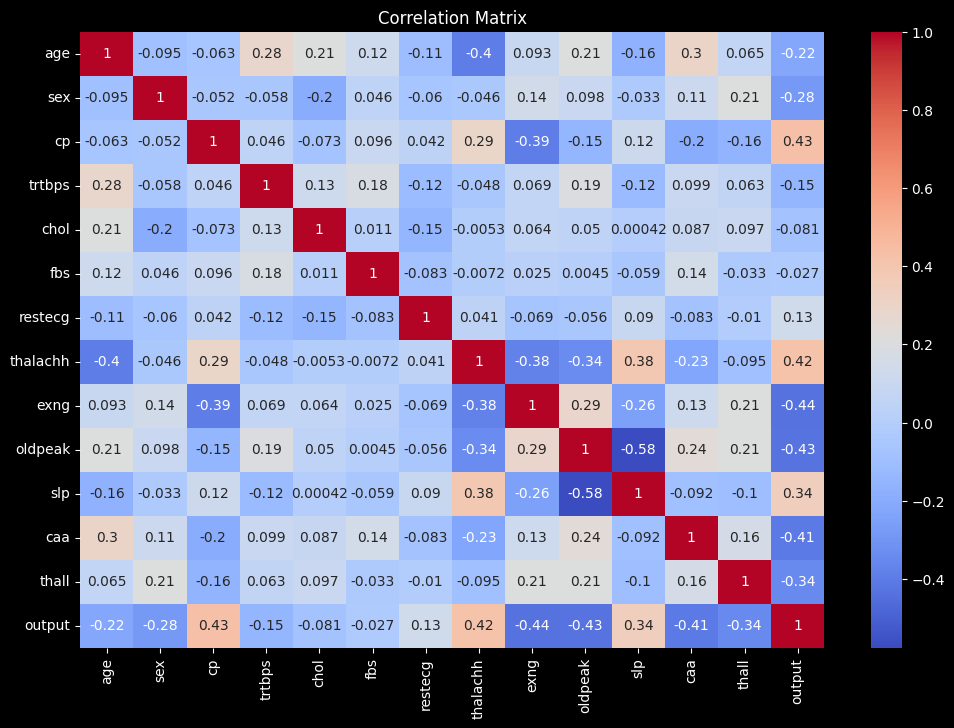

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlation matrix
correlation_matrix = df.corr()

# Display correlation matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()





## Feature Engineering 🔧

There is a couple things you can do to handle highly corrolated values, and it usually depends on the context, domain and objective.

1. **Remove One of the Highly Correlated Variables**: This is the simplest solution. If two variables are highly correlated, you can remove one of them. This is the easiest way to deal with multicollinearity. However, the challenge is to identify which variable to remove. You can remove the variable that is less related to the target variable.

2. **Combine the Variables**: If two variables are highly correlated, you can combine them into a single variable. This can be done by taking the average of the two variables or by using PCA to create a new variable that captures the variance of the two variables.

3. **Use Regularization**: Regularization methods like Lasso and Ridge regression can handle multicollinearity by adding a penalty to the coefficients of the correlated variables. This will reduce the impact of multicollinearity on the model.

4. **Do Nothing**: Sometimes, multicollinearity is not a problem. If the goal is to make predictions, multicollinearity may not be an issue. However, if the goal is to interpret the coefficients of the model, multicollinearity can be a problem.

When dropping the highly corrolated features it is important to make sure that 

In [17]:
upper_matrix = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool_))

sorted_upper_matrix = np.sort(upper_matrix.values.flatten())[::-1]

threshold_index = int(len(sorted_upper_matrix) * 0.01)

sorted_upper_matrix = np.sort(sorted_upper_matrix, kind='stable')


threshold_value = sorted_upper_matrix[threshold_index]

print(threshold_value)

# to_drop = [column for column in upper_matrix.columns if any(upper_matrix[column] > upper_one_percent)]

# print(f"Columns to drop: {to_drop}")

-0.4356007617136187


     slp
0      0
1      0
2      2
3      2
4      2
..   ...
298    1
299    1
300    1
301    1
302    1

[302 rows x 1 columns]


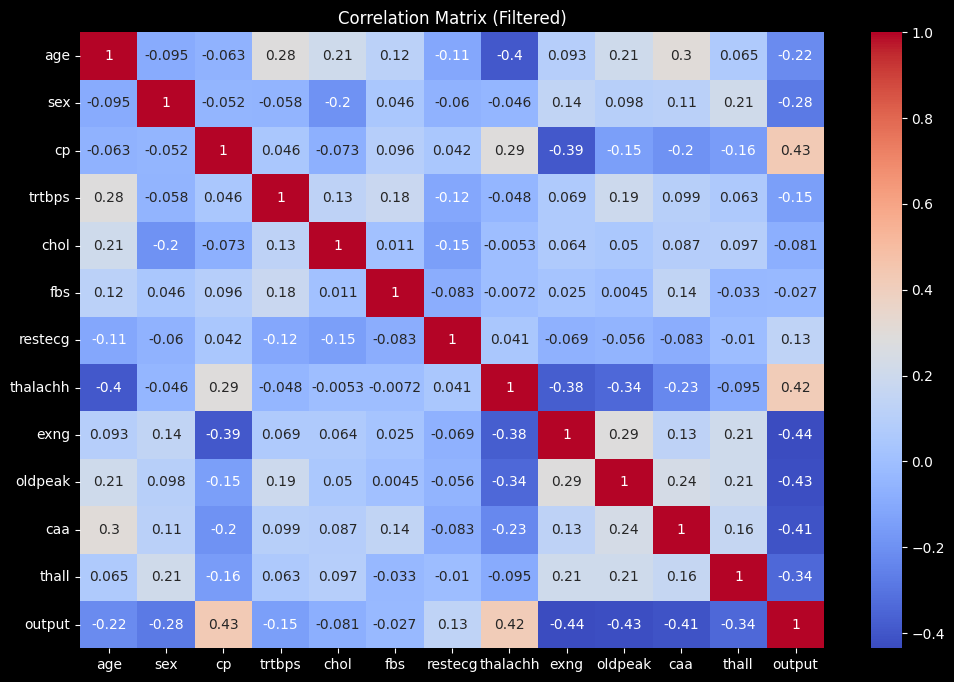

In [19]:
# Remove correlated variables
correlated_features = set()
threshold = 0.5

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

df_filtered = df.drop(correlated_features, axis=1)

#Print the values that will be dropped
dropped_values = df.columns.difference(df_filtered.columns)
print(df[dropped_values])


# Print the resulting data with correlated values removed
plt.figure(figsize=(12, 8))
sns.heatmap(df_filtered.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix (Filtered)')
plt.show()


One of the first steps is to look for corrolated values, this is going to help us to understand the data and to see if there are any values that are not important for the model.

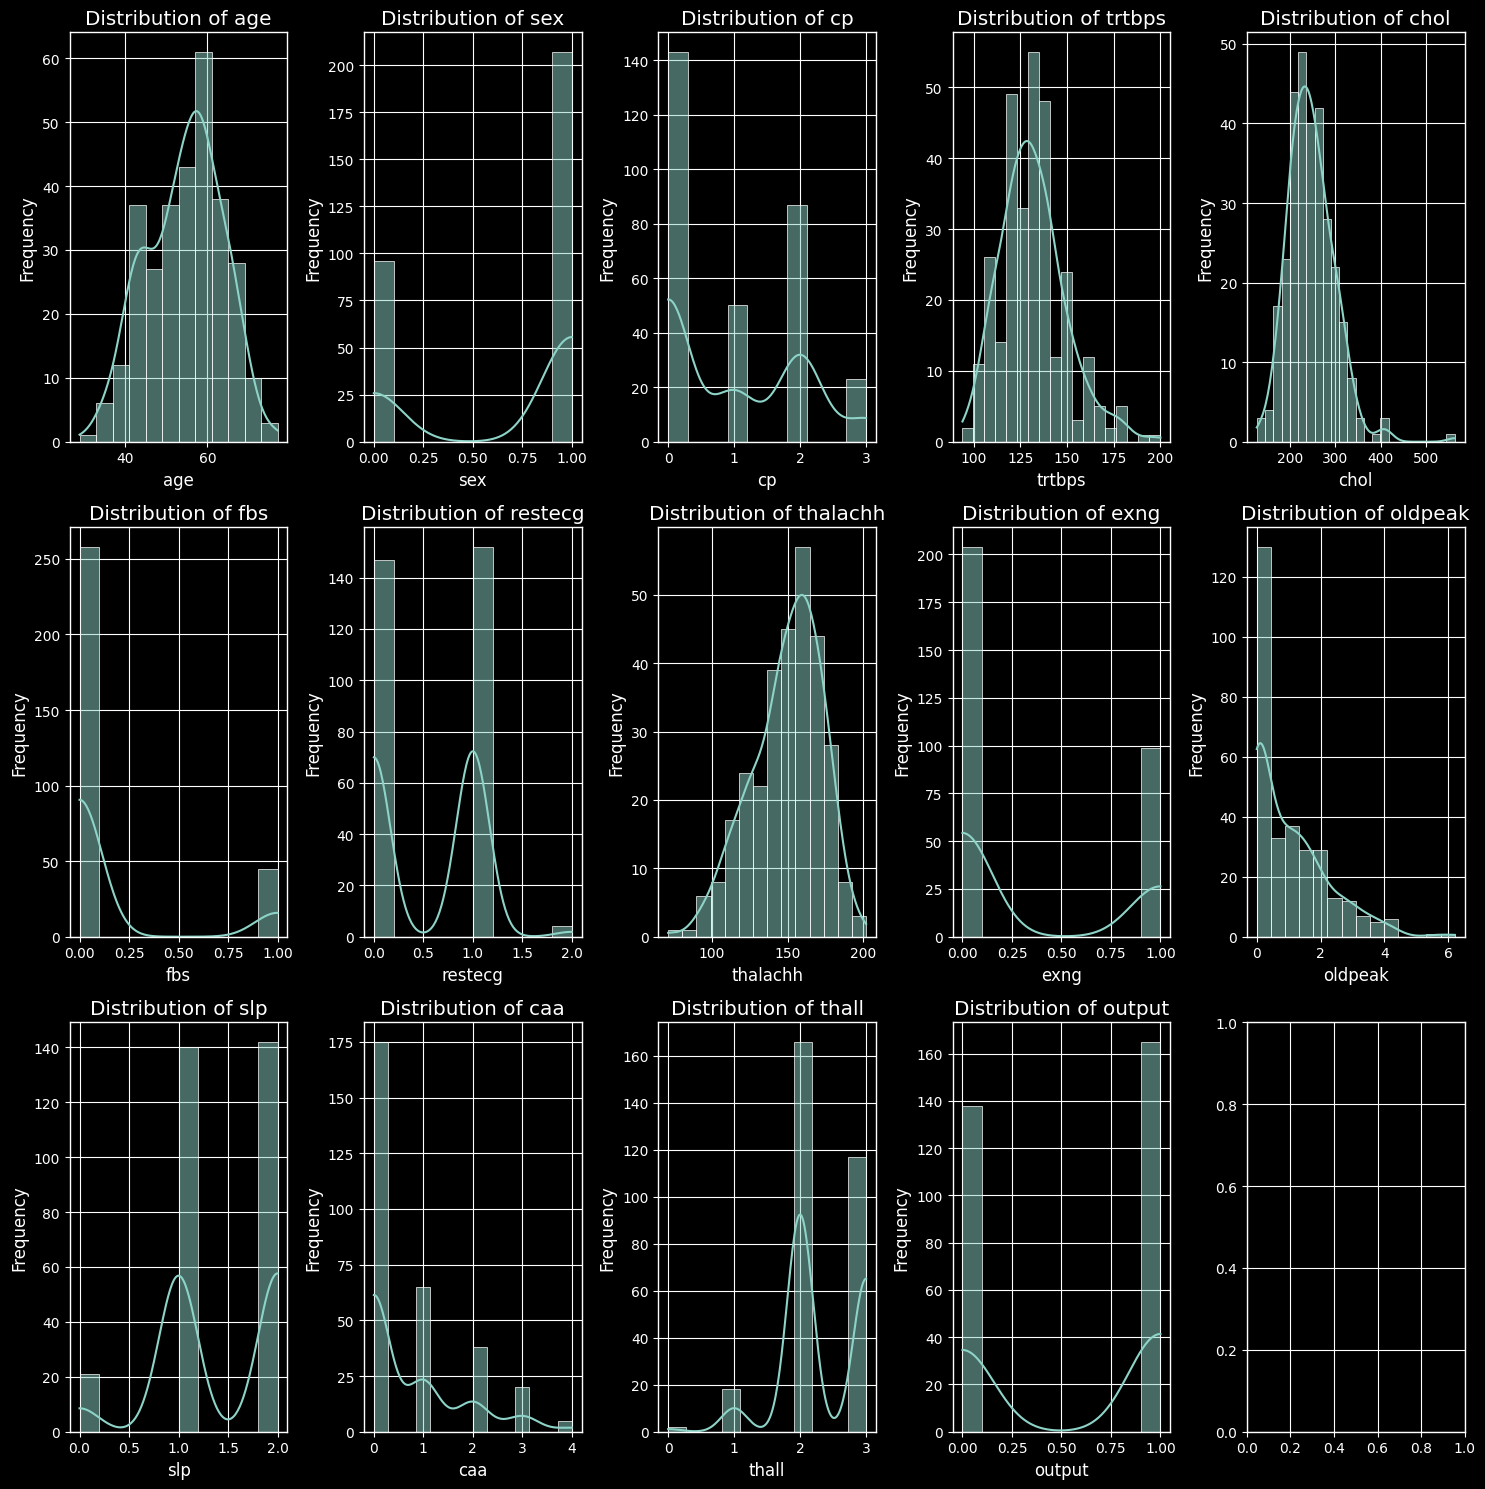

In [72]:
# Create a 3x5 grid for subplots
fig, axes = plt.subplots(3, 5, figsize=(15, 15))

# Iterate over each column in the dataset
for i, column in enumerate(df.columns):
    # Calculate the row and column index for the subplot
    row = i // 5
    col = i % 5
    
    # Plot the distribution of the column
    sns.histplot(df[column], kde=True, ax=axes[row, col])
    axes[row, col].set_title(f"Distribution of {column}")
    axes[row, col].set_xlabel(column)
    axes[row, col].set_ylabel("Frequency")

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()




## Model Building 🧠
Build and train machine learning models on the prepared dataset. 

---

## Model Evaluation 📝
Evaluate the performance of the trained models using appropriate metrics. 

---

## Conclusion 🏁
Summarize the findings, discuss the limitations, and suggest future improvements. 

---


In [78]:
# Normalize the data
scaler = MinMaxScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# Display the normalized data
print("Normalized Data:")
print(df_normalized)

# Display the non-normalized data
print("\nNon-Normalized Data:")
print(df)


Normalized Data:
          age  sex        cp    trtbps      chol  fbs  restecg  thalachh  \
0    0.708333  1.0  1.000000  0.481132  0.244292  1.0      0.0  0.603053   
1    0.166667  1.0  0.666667  0.339623  0.283105  0.0      0.5  0.885496   
2    0.250000  0.0  0.333333  0.339623  0.178082  0.0      0.0  0.770992   
3    0.562500  1.0  0.333333  0.245283  0.251142  0.0      0.5  0.816794   
4    0.583333  0.0  0.000000  0.245283  0.520548  0.0      0.5  0.702290   
..        ...  ...       ...       ...       ...  ...      ...       ...   
298  0.583333  0.0  0.000000  0.433962  0.262557  0.0      0.5  0.396947   
299  0.333333  1.0  1.000000  0.150943  0.315068  0.0      0.5  0.465649   
300  0.812500  1.0  0.000000  0.471698  0.152968  1.0      0.5  0.534351   
301  0.583333  1.0  0.000000  0.339623  0.011416  0.0      0.5  0.335878   
302  0.583333  0.0  0.333333  0.339623  0.251142  0.0      0.0  0.786260   

     exng   oldpeak  slp   caa     thall  output  
0     0.0  0.370968

In [80]:
# Apply label encoding to the normalized data
label_encoder = LabelEncoder()
df_encoded = df_normalized.apply(label_encoder.fit_transform)

# Display the encoded data
print(df_encoded)


     age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  \
0     29    1   3      31    64    1        0        49     0       22    0   
1      3    1   2      22    80    0        1        84     0       32    0   
2      7    0   1      22    35    0        0        71     0       14    2   
3     22    1   1      14    67    0        1        76     0        8    2   
4     23    0   0      14   145    0        1        62     1        6    2   
..   ...  ...  ..     ...   ...  ...      ...       ...   ...      ...  ...   
298   23    0   0      28    71    0        1        23     1        2    1   
299   11    1   3       8    93    0        1        32     0       12    1   
300   34    1   0      30    26    1        1        40     0       31    1   
301   23    1   0      22     1    0        1        16     1       12    1   
302   23    0   1      22    67    0        0        73     0        0    1   

     caa  thall  output  
0      0      1       1  

In [87]:
feature_col_nontree=df_encoded.columns.to_list()
feature_col_nontree.remove('output')
print(feature_col_nontree)

y=df_encoded["output"].values


['age', 'sex', 'cp', 'trtbps', 'chol', 'fbs', 'restecg', 'thalachh', 'exng', 'oldpeak', 'slp', 'caa', 'thall']


In [88]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,roc_auc_score
from sklearn.preprocessing import RobustScaler,MinMaxScaler,StandardScaler
acc_log=[]

kf=model_selection.StratifiedKFold(n_splits=5)
for fold , (trn_,val_) in enumerate(kf.split(X=df_encoded,y=y)):
    
    X_train=df_encoded.loc[trn_,feature_col_nontree]
    y_train=df_encoded.loc[trn_,"output"]
    
    X_valid=df_encoded.loc[val_,feature_col_nontree]
    y_valid=df_encoded.loc[val_,"output"]
    
    #print(pd.DataFrame(X_valid).head())
    ro_scaler=MinMaxScaler()
    X_train=ro_scaler.fit_transform(X_train)
    X_valid=ro_scaler.transform(X_valid)
    
    
    clf=LogisticRegression()
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_valid)
    print(f"The fold is : {fold} : ")
    print(classification_report(y_valid,y_pred))
    acc=roc_auc_score(y_valid,y_pred)
    acc_log.append(acc)
    print(f"The accuracy for Fold {fold+1} : {acc}")
    pass

The fold is : 0 : 
              precision    recall  f1-score   support

           0       0.91      0.75      0.82        28
           1       0.82      0.94      0.87        33

    accuracy                           0.85        61
   macro avg       0.86      0.84      0.85        61
weighted avg       0.86      0.85      0.85        61

The accuracy for Fold 1 : 0.8446969696969697
The fold is : 1 : 
              precision    recall  f1-score   support

           0       0.85      0.82      0.84        28
           1       0.85      0.88      0.87        33

    accuracy                           0.85        61
   macro avg       0.85      0.85      0.85        61
weighted avg       0.85      0.85      0.85        61

The accuracy for Fold 2 : 0.8501082251082251
The fold is : 2 : 
              precision    recall  f1-score   support

           0       0.79      0.82      0.81        28
           1       0.84      0.82      0.83        33

    accuracy                       